In [1]:
import os
import time
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

import model_prep_and_evals as mpe 
import A_data_sampling_workflow.sample_rasters as sr

from shapely.geometry import Polygon

import geopandas as gpd
import rioxarray as rioxr

import rasterio
from rasterio.crs import CRS

from shapely.geometry import box

import planetary_computer as pc

from skimage.feature import graycomatrix, graycoprops

In [2]:
box_carp = Polygon( [
            [-119.5144546684841,34.39274397377842],
            [-119.5144546684841,34.39193499538564],
            [-119.51344346289721,34.39193499538564],
            [-119.51344346289721,34.39274397377842],
            [-119.5144546684841,34.39274397377842]
          ])
itemid_carp = 'ca_m_3411936_se_11_060_20200521'

raster = sr.rioxr_from_itemid(itemid_carp, box_carp, "EPSG:4326")[:,0:150,0:150]
raster

<xarray.DataArray (band: 4, y: 150, x: 150)>
[90000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 2.688e+05 2.688e+05 ... 2.689e+05 2.689e+05
  * y            (y) float64 3.809e+06 3.809e+06 ... 3.808e+06 3.808e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                0
    datetime:                  2020-05-21 00:00:00+00:00

In [10]:
raster[:,16:136,16:136]

<xarray.DataArray (band: 4, y: 120, x: 120)>
[57600 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 2.689e+05 2.689e+05 ... 2.689e+05 2.689e+05
  * y            (y) float64 3.809e+06 3.809e+06 ... 3.808e+06 3.808e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                0
    datetime:                  2020-05-21 00:00:00+00:00

In [3]:
window_radii = [1,2,3,4,5]
times = []

# parameters for GLCM 
distances = [1]     
angles = [0, np.pi/2] # East, North

y_len = raster.shape[1]
x_len = raster.shape[2]

In [4]:
for window_r in window_radii:

    contrast = {angles[0]: np.zeros((4,y_len,x_len)), 
                angles[1]: np.zeros((4,y_len,x_len))}

    correlation = {angles[0]: np.zeros((4,y_len,x_len)), 
                   angles[1]: np.zeros((4,y_len,x_len))}

    # START TIMING
    t0 = time.time()
    for y in range(y_len):
        for x in range(x_len):
            # this window has shape (4, 2*window_r +1, 2*window_r +1)
            window = raster[:, y-window_r:y+window_r+1, x-window_r:x+window_r+1]

            # check that the window has desired size (no edges)
            if (window.shape[1] != 2*window_r+1) | (window.shape[2] != 2*window_r+1):
                contrast[y,x] = np.nan
                correlation[y,x] = np.nan  
            else:            

            # calculate GLCM on that small window, 
            # for a given angle, across all bands
                for angle in angles:
                    for band in range(4):
                        glcm = graycomatrix(window[band],  # can only calculate one band at a time
                                    distances=distances,
                                    angles=[angle])

                        # extract contrast and correlation from GLCM
                        contrast[angle][band,y,x] = graycoprops(glcm, 'contrast')[0,0]
                        correlation[angle][band,y,x] = graycoprops(glcm, 'correlation')[0,0]
    # FINISH TIMING
    times.append(time.time() - t0)
    np.savetxt('glcm_times.txt',np.array(times),fmt='%.10f')

In [5]:
times

[379.42848801612854,
 369.49636054039,
 357.91681933403015,
 345.84434700012207,
 339.92726278305054]

In [6]:
window_radii

[1, 2, 3, 4, 5]

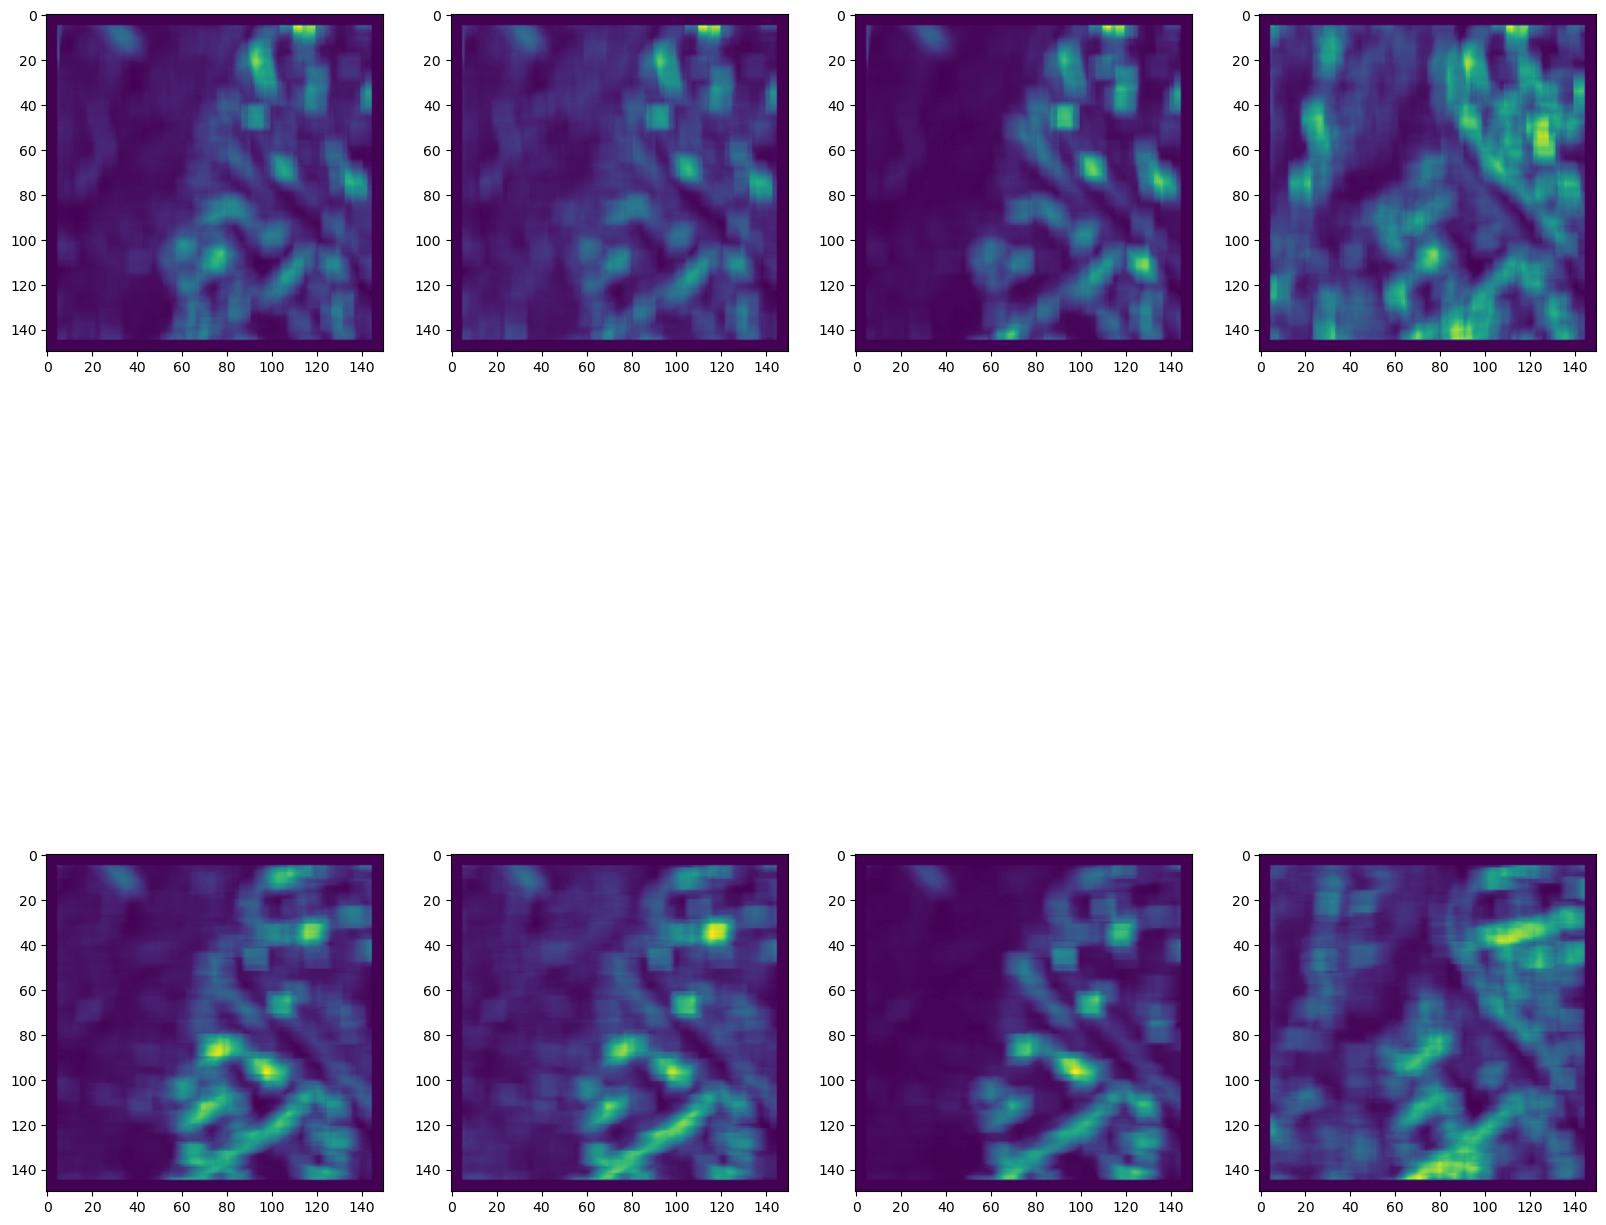

In [8]:
fig, ax = plt.subplots(2,4,figsize=(20, 20))  

for i,angle in zip(range(2),angles):
    for band in range(4):
        ax[i,band].imshow(contrast[angle][band])
plt.show()

In [14]:
X = np.zeros((120,120))

# only calculat on inner section of image (leave a margin of 15 pixels along edges)
for y in range(16,136):
    for x in range(16,136):
        # this window has shape (4, 2*window_r +1, 2*window_r +1)
        window = raster[:, y-window_r:y+window_r+1, x-window_r:x+window_r+1]

        # check that the window has desired size (no edges)
        if (window.shape[1] != 2*window_r+1) | (window.shape[2] != 2*window_r+1):
            contrast[y,x] = np.nan
            correlation[y,x] = np.nan  
        else:            

        # calculate GLCM on that small window, 
        # for a given angle, across all bands
            glcm = graycomatrix(window[0], 
                        distances=distances,
                        angles=[0])

            # extract contrast
            X[y-16,x-16] = graycoprops(glcm, 'contrast')[0,0]


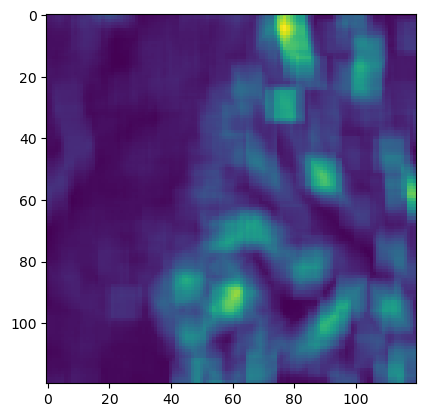

In [16]:
plt.imshow(X)
plt.show()

In [17]:
X.shape

(120, 120)